# Estimating Time from Referral to Procurement

**Objective:** Predict the time interval between hospital referral and organ procurement.

**Features:**

- Patient Demographics: `Age`, `Gender`, `Race`
- Medical Details: `Cause_of_Death_UNOS`, `Mechanism_of_Death`, `Circumstances_of_Death`, `ABO_BloodType`, `ABO_Rh`, `HeightIn`, `WeightKg`
- Referral and Authorization Details: `Tissue_Referral`, `Eye_Referral`, `brain_death`, `approached`, `authorized`
- Timing Information: `time_brain_death`, `time_asystole`, `time_referred`, `time_approached`, `time_authorized`, `Referral_Year`, `Referral_DayofWeek`, `Procured_Year`
- Outcome: `outcome_heart`, `outcome_liver`, `outcome_kidney_left`, `outcome_kidney_right`, `outcome_lung_left`, `outcome_lung_right`, `outcome_intestine`, `outcome_pancreas`

**Target:** `time_procured` - `time_referred`

`time_to_procurement`: Calculated as the difference between time_procured and time_referred

**Model Type:** Regression (Linear Regression, Random Forest Regression, Gradient Boosting Regression)

In [1]:
import pandas as pd
# load data bases
df = pd.read_csv('data/referrals.csv')

/tmp/ipykernel_8385/449642640.py:3: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/referrals.csv')


# Exploratory data Analysis

In [2]:
df.shape

(133101, 38)

We calculate the total number of organ procured by health organization.

In [3]:
df[['time_procured', 'time_referred']].count()

time_procured      9502
time_referred    133101
dtype: int64

In total we got 9502 organs procured. We need to subset our dataset to get only this part.

In [4]:
def filter_data():
    df_sub = df.loc[df['time_procured'].notnull() & df['time_referred'].notnull()].copy()
    return df_sub
df_sub = filter_data()
df_sub.shape

(9502, 38)

## What type is my data?

In [5]:
type(df_sub.loc[df_sub['time_procured'].notna()]['time_procured'].reset_index(drop=True)[1]) # type: ignore

str

In [6]:
type(df_sub.loc[df_sub['time_referred'].notna()]['time_referred'].reset_index(drop=True)[1]) # type: ignore

str

Since both fields are strings, we need to convert into time data type

In [7]:
df_sub['time_referred_time'] = pd.to_datetime(df_sub['time_referred'], format='ISO8601')
df_sub['time_procured_time'] = pd.to_datetime(df_sub['time_procured'], format='ISO8601')

In [8]:
df_sub['time_to_procurement'] = (df_sub['time_procured_time'] - df_sub['time_referred_time']).dt.days
df_sub['time_to_procurement']

25        4
42        2
49        2
65        4
70        6
         ..
133010    7
133023    3
133026    4
133081    3
133090    1
Name: time_to_procurement, Length: 9502, dtype: int64

# Is ther any outlier?

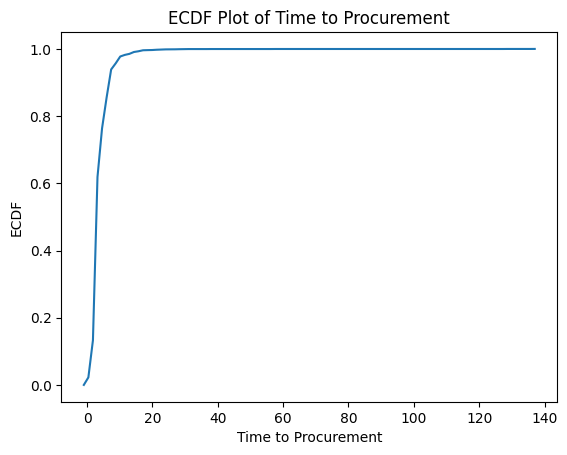

In [9]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the ECDF
ecdf = sm.distributions.ECDF(df_sub['time_to_procurement'])

# Generate x values for the ECDF plot
x = np.linspace(min(df_sub['time_to_procurement']), max(df_sub['time_to_procurement']), num=100)

# Calculate the y values for the ECDF plot
y = ecdf(x)

# Plot the ECDF
plt.plot(x, y)
plt.xlabel('Time to Procurement')
plt.ylabel('ECDF')
plt.title('ECDF Plot of Time to Procurement')

plt.show()

In [10]:
y[20]

np.float64(0.9988423489791622)

As we can see, the 99% of the date is kept with data from 0 to 20 days. So we keep this data with us.

In [11]:
df_model = df_sub.loc[
    (df_sub['time_to_procurement'] <= 20) & 
    (df_sub['time_to_procurement'] > 0) # one negative value
    ].copy()

In order to visualize the data we plot again the distribution:

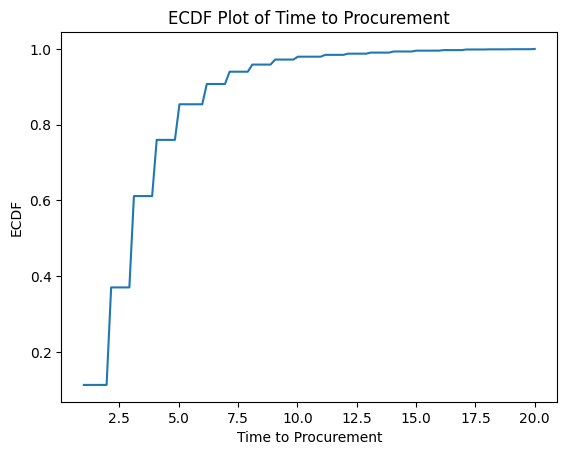

In [12]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the ECDF
ecdf = sm.distributions.ECDF(df_model['time_to_procurement'])

# Generate x values for the ECDF plot
x = np.linspace(min(df_model['time_to_procurement']), max(df_model['time_to_procurement']), num=100)

# Calculate the y values for the ECDF plot
y = ecdf(x)

# Plot the ECDF
plt.plot(x, y)
plt.xlabel('Time to Procurement')
plt.ylabel('ECDF')
plt.title('ECDF Plot of Time to Procurement')

plt.show()

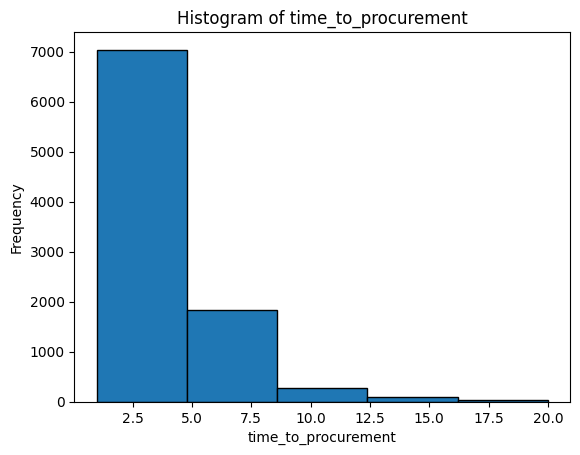

In [13]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(df_model['time_to_procurement'], bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('time_to_procurement')
plt.ylabel('Frequency')
plt.title('Histogram of time_to_procurement')

# Show the plot
plt.show()

# Now we need develop our model

## features

In [14]:
df_model[['ABO_BloodType', 'ABO_Rh']] # we combine strings to create a new 
# column to use as a feature 'bold_type' 

,ABO_BloodType,ABO_Rh
25,O,Positive
42,A,Positive
49,O,Positive
65,A2,Positive
70,O,Positive
...,...,...
133010,A1,Positive
133023,O,Positive
133026,A,Positive
133081,O,Negative


In [15]:
df_model['blod_type'] = df_model['ABO_BloodType'] + '-' + df_model['ABO_Rh']

In [16]:
df_model[['ABO_BloodType', 'ABO_Rh', 'blod_type']]

,ABO_BloodType,ABO_Rh,blod_type
25,O,Positive,O-Positive
42,A,Positive,A-Positive
49,O,Positive,O-Positive
65,A2,Positive,A2-Positive
70,O,Positive,O-Positive
...,...,...,...
133010,A1,Positive,A1-Positive
133023,O,Positive,O-Positive
133026,A,Positive,A-Positive
133081,O,Negative,O-Negative


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features = ['Age', 'Gender', 'Race', 'HeightIn', 'WeightKg', 'blod_type', 'brain_death']

X = pd.get_dummies(df_model[features], drop_first=True)
y = df_model['time_to_procurement']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 


In [18]:
# Train and evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# apply cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Linear Regression Cross Validation MAE:", -scores.mean())

Linear Regression MAE: 1.554226591314328
Linear Regression RMSE: 2.1474735599910244
Linear Regression Cross Validation MAE: 1.6511520423194814


In [21]:
# Train and evaluate Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Regression MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Random Forest Regression Cross Validation MAE:", -scores.mean())

Random Forest Regression MAE: 1.6591419320021588
Random Forest Regression RMSE: 2.3093336390502355
Random Forest Regression Cross Validation MAE: 1.7473553486902915


In [22]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
# Train XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=1000)
xg_reg.fit(X_train, y_train,
           eval_set=[(X_test, y_test)],
           verbose=False)

# Predict and evaluate
y_pred = xg_reg.predict(X_test)
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

scores = -1 * cross_val_score(xg_reg, X, y,
                                cv=5,
                                scoring='neg_mean_absolute_error')
print("MAE scores:\n", scores.mean())

XGBoost MAE: 1.588902894863874
XGBoost RMSE: 2.21646494315956
MAE scores:
 1.6784941580888446


In [23]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [24]:
print("Linear Regression SMAPE:", smape(y_test, y_pred_lr))
print("Random Forest Regression SMAPE:", smape(y_test, y_pred_rf))
print("XGBoost SMAPE:", smape(y_test, y_pred))


Linear Regression SMAPE: 43.5886430407095
Random Forest Regression SMAPE: 45.41735420308041
XGBoost SMAPE: 44.2483867030896


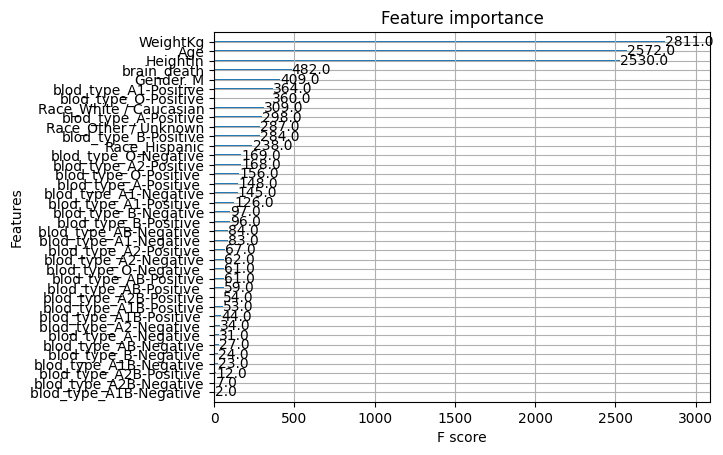

In [25]:
# Plot feature importance
xgb.plot_importance(xg_reg)
plt.show()